In [1]:
import requests
import time
import json
import pandas as pd
import numpy as np
from warnings import warn
import re
import pickle
import os
from datetime import date, datetime
import matplotlib.pyplot as plt

# create tmp folder if not exists
path = 'tmp'

if not os.path.exists(path):
    os.mkdir(path)

## Исследование заработной платы по описанию вакансии
**Задача:** выявить факторы, которые больше всего влияют на размер заработной платы.
**Ограничения:**
- только вакансии со словом "аналитик"
- только Москва

На этом занятии будем исследовать данные с HH. Для этого нам пригодится [HH API](https://dev.hh.ru/).

### Что такое API?
![](https://osipenkov.ru/wp-content/uploads/2023/01/api-google-analytics-8.png)

### Как с ним работать?

Надо делать запросы (requests). А как? Есть ли общепринятая форма? Да, это протокол HTTP (HTTPS - его "защищенная" форма):

![](https://res.cloudinary.com/idiomprog/image/upload/v1616226497/httpmsgstructure2_htshjp.png)

Какие вообще бывают запросы?

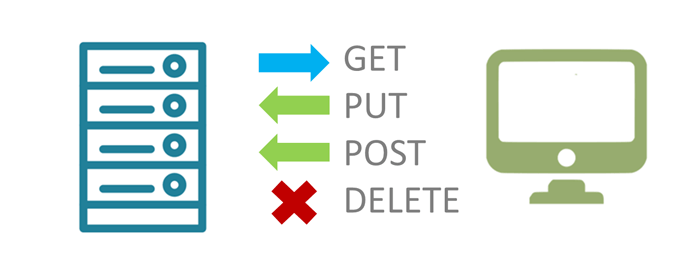

Собственно, API регламентирует:

1. Какой тип запроса надо сделать;
2. По какому адресу;
3. С какими параметрами;
4. И что мы в ответ получим.

А как понять, что все получилось?

![](https://www.sempeak.com/imaj/seo-baslangic-rehberi/durum-kodlari.jpeg)

Наиболее популярные ответы:

![](https://sun9-58.userapi.com/impf/c837532/v837532092/35350/G49aBNgrsFU.jpg?size=638x479&quality=96&sign=288ef2485ff3d259c48cab0ad8f7d937&c_uniq_tag=8sJaIH4O8ior3oA0nhmek_DqYHT0-MG5iMvoCrAbu9I&type=album)

В этот раз нам пригодятся две "ручки":

1. `https://api.hh.ru/vacancies`;
2. `https://api.hh.ru/vacancies/<vacancy_id>`.

### Используя первую, получите id всех вакансий

Подумайте: надо ли обрабатывать отрицательные запросы?

In [ ]:
url = 'https://api.hh.ru/vacancies'

params = {
    'text': 'NAME:Аналитик',  # в имени должно быть слово "Аналитик"
    'area': 1,  # поиск ощуществляется по вакансиям города Москва
    'page': 0,  # индекс страницы поиска на HH
    'per_page': 100,  # кол-во вакансий на 1 странице
    'only_with_salary': 'true'  # берем только те вакансии, где указана заработная плата
}

response = requests.get(url, params)

if response.status_code != 200:
    print(f'request is not successful: code {response.status_code}')
else:
    content = response.content.decode()

    # close connection as we have already extracted content
    response.close()

    # process content
    content_json = json.loads(content)

    vacancy_ids = [vacancy['id'] for vacancy in content_json['items']]

Всегда важно сохранять промежуточные данные, иначе вы рискуете потерять много времени:

In [ ]:
with open('tmp/vacancy_ids.pickle', 'wb') as outfile:
    pickle.dump(vacancy_ids, outfile)

In [ ]:
del vacancy_ids

In [2]:
with open('tmp/vacancy_ids.pickle', 'rb') as infile:
    vacancy_ids = pickle.load(infile)

**Задача**

Собрать информацию по каждому id:

1. Правильно составить url;
2. Правильно (с нужными параметрами) сделать запрос (тут параметры не надо вставлять);
3. Проверить, какой вы получили ответ;
4. Собрать из response json, превратить его в словарь;
5. Сохранить в список;
6. Повторить все с всеми 100 ids.

### Используя вторую "ручку", получите id всех вакансий

Не забывайте сохранять полученные данные!

Также настройте логгирование, чтобы понимать, на каком моменте вы сейчас находитесь.

In [18]:
response = requests.get('https://api.hh.ru/vacancies/88348260')

if response.status_code == 200:
    response_content = response.content.decode()  # response_dict = response.json()
    response_dict = json.loads(response_content)
else:
    warn(f'Something went wrong, response status code is {response.status_code}')

In [23]:
if os.path.exists('tmp/vacancies.pickle'):
    print('Nice, vacancies are already there!')
    
    with open('tmp/vacancies.pickle', 'rb') as infile:
        vacancies = pickle.load(infile)
        
else:
    vacancies = []
    
    total = len(vacancy_ids)
    
    for index, id_ in enumerate(vacancy_ids):
        count = index + 1
        
        if count % 5 == 0:
            print(f'processing vacancy {id_}... ({count} / {total})')
        
        url = f'https://api.hh.ru/vacancies/{id_}'
    
        response = requests.get(url)
    
        if response.status_code == 200:
            response_content = response.content.decode()
            response_dict = json.loads(response_content)
            vacancies.append(response_dict)
            
        else:
            warn(f'Something went wrong, response status code is {response.status_code}')
    
        time.sleep(0.5)

    with open('tmp/vacancies.pickle', 'wb') as outfile:
        pickle.dump(vacancies, outfile)

Nice, vacancies are already there!


In [24]:
vacancies[0]

{'id': '95839402',
 'premium': False,
 'billing_type': {'id': 'standard', 'name': 'Стандарт'},
 'relations': [],
 'name': 'Системный аналитик',
 'insider_interview': None,
 'response_letter_required': False,
 'area': {'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'},
 'salary': {'from': 500000, 'to': None, 'currency': 'RUR', 'gross': False},
 'type': {'id': 'open', 'name': 'Открытая'},
 'address': None,
 'allow_messages': True,
 'experience': {'id': 'between3And6', 'name': 'От 3 до 6 лет'},
 'schedule': {'id': 'fullDay', 'name': 'Полный день'},
 'employment': {'id': 'full', 'name': 'Полная занятость'},
 'department': None,
 'contacts': None,
 'description': '<strong>Обязанности:</strong> <p>Нахожусь в поиске системного аналитика - бизнес партнера. Суть бизнес проекта и условия партнерства опишу после успешных переговоров. Предполагаемая прибыль в первый месяц проекта от 500 тыс руб.</p> <p>Важно, чтобы основная работа, если она имеется, занимала до 50% рабочего времени.

In [10]:
salary_params = ['from', 'to', 'currency', 'gross']

def process_vacancy(vacancy: dict) -> dict:
    
    vacancy_processed = {}
    vacancy_processed['id'] = vacancy.get('id')

    # salary
    salary_exists = vacancy.get('salary') is not None
    
    for sp in salary_params:
        if salary_exists:
            vacancy_processed[f'salary_{sp}'] = vacancy['salary'].get(sp)
        else:
            vacancy_processed[f'salary_{sp}'] = None

    # address
    address = vacancy.get('address')

    if address is None:
        vacancy_processed['lat'] = None
        vacancy_processed['lng'] = None
    else:
        vacancy_processed['lat'] = address['lat']
        vacancy_processed['lng'] = address['lng']

    # experience
    experience = vacancy.get('experience')

    if experience is None:
        vacancy_processed['experience'] = None
    else:
        vacancy_processed['experience'] = experience['id']

    # key_skills
    key_skills = vacancy.get('key_skills')

    if key_skills is None:
        vacancy_processed['key_skills'] = None
    else:
        if len(key_skills) == 0:
            vacancy_processed['key_skills'] = None
        else:
            vacancy_processed['key_skills'] = [skill['name'] for skill in key_skills]

    return vacancy_processed

In [25]:
if os.path.exists('tmp/vacancies_processed.pickle'):
    print('Nice, processed vacancies are already there!')
    
    with open('tmp/vacancies_processed.pickle', 'rb') as infile:
        vacancies_processed = pickle.load(infile)
        
else:
    vacancies_processed = [process_vacancy(v) for v in vacancies]
    
    with open('tmp/vacancies_processed.pickle', 'wb') as outfile:
        pickle.dump(vacancies_processed, outfile)

Nice, processed vacancies are already there!


#### Перейдем к pandas

Сделайте `pd.DataFrame` из полученного списка.

In [30]:
pd.DataFrame(vacancies)

,id,premium,billing_type,relations,name,insider_interview,response_letter_required,area,salary,type,...,apply_alternate_url,has_test,test,alternate_url,working_days,working_time_intervals,working_time_modes,accept_temporary,languages,approved
0,95839402,False,"{'id': 'standard', 'name': 'Стандарт'}",[],Системный аналитик,None,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 500000, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/applicant/vacancy_response?vacan...,False,None,https://hh.ru/vacancy/95839402,[],[],[],False,[],True
1,95150405,False,"{'id': 'standard', 'name': 'Стандарт'}",[],Аналитик данных (SQL / Excel / Power BI),None,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 70000, 'to': 100000, 'currency': 'RUR...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/applicant/vacancy_response?vacan...,False,None,https://hh.ru/vacancy/95150405,[],[],[],True,[],True
2,96996640,False,"{'id': 'standard', 'name': 'Стандарт'}",[],Стажер-аналитик,None,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': None, 'to': 40000, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/applicant/vacancy_response?vacan...,True,{'required': True},https://hh.ru/vacancy/96996640,[],[],[],False,[],True
3,95175172,False,"{'id': 'standard', 'name': 'Стандарт'}",[],Директор по бизнес-процессам / системный анали...,None,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 400000, 'to': 1000000, 'currency': 'R...","{'id': 'anonymous', 'name': 'Анонимная'}",...,https://hh.ru/applicant/vacancy_response?vacan...,False,None,https://hh.ru/vacancy/95175172,[],[],[],False,[],True
4,95471014,False,"{'id': 'standard', 'name': 'Стандарт'}",[],Разработчик-аналитик Python Oracle,None,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': None, 'to': 250000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/applicant/vacancy_response?vacan...,False,None,https://hh.ru/vacancy/95471014,[],[],[],False,[],True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95624535,False,"{'id': 'standard', 'name': 'Стандарт'}",[],Стажер - BI Аналитик,None,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 40000, 'to': 40000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/applicant/vacancy_response?vacan...,False,None,https://hh.ru/vacancy/95624535,[],[],[],False,[],True
96,96827034,False,"{'id': 'standard', 'name': 'Стандарт'}",[],Бизнес-аналитик,None,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 200000, 'to': 220000, 'currency': 'RU...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/applicant/vacancy_response?vacan...,False,None,https://hh.ru/vacancy/96827034,[],[],[],False,[],True
97,96724381,False,"{'id': 'standard_plus', 'name': 'Стандарт плюс'}",[],Ведущий аналитик,None,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 175000, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/applicant/vacancy_response?vacan...,False,None,https://hh.ru/vacancy/96724381,[],[],[],False,"[{'id': 'eng', 'name': 'Английский', 'level': ...",True
98,95219087,False,"{'id': 'standard_plus', 'name': 'Стандарт плюс'}",[],Младший аналитик (IT),None,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 100000, 'to': 140000, 'currency': 'RU...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/applicant/vacancy_response?vacan...,False,None,https://hh.ru/vacancy/95219087,[],[],[],False,[],True


In [28]:
vacancies_df = pd.DataFrame(vacancies_processed)
vacancies_df.head()

,id,salary_from,salary_to,salary_currency,salary_gross,lat,lng,experience,key_skills
0,95839402,500000.0,NaN,RUR,False,NaN,NaN,between3And6,"[системный аналитик, UML, BPMN, API, PostgreSQL]"
1,95150405,70000.0,100000.0,RUR,True,NaN,NaN,noExperience,"[SQL, MS SQL, ETL, Power BI, Google Analytics,..."
2,96996640,NaN,40000.0,RUR,True,NaN,NaN,noExperience,None
3,95175172,400000.0,1000000.0,RUR,False,NaN,NaN,between3And6,None
4,95471014,NaN,250000.0,RUR,False,55.771758,37.620734,between3And6,"[PLM, ORACLE, Agile Project Management, WFM, Р..."


In [29]:
vacancies_df.to_excel('vacancies_data.xlsx', index=None)

#### Разберемся с таргетом

In [ ]:
vacancies_df.head()

In [ ]:
(vacancies_df['salary_from'].notna() & vacancies_df['salary_to'].notna()).sum()

In [ ]:
# ЧТО ДЕЛАТЬ С salary_from и salary_to?

#1 Посчитать среднее значение
# + получаем разумную метрику
# - остается слишком мало наблюдений

#2 Заместить пропущенные значения
#2.1 Считаем, что одна метрика может заменить другую
# +это просто сделать
# -нарушается консистентность таргета

#2.2 Экстраполировать пропущенное значение исходя из закономерностей в данных
# -сложнее
# -мы "придумываем" таргет сами, НО
# +у нас есть возможность контролировать "качество" этого таргета
# +самый интересный вариант

# РЕШЕНИЕ: попробуем восстановить пропущенные значения с помощью ML
# можем перебрать несколько моделей и выбрать для восстановления ту, которая будет предсказывать лучше
# LR, RF, GB

#### Немного про .itertuples()

In [ ]:
def convert_gross(series: pd.Series) -> float:
    if series['salary_gross']:
        return series.iloc[0] * 0.87
    else:
        return series.iloc[0]

In [ ]:
from collections import namedtuple

def convert_gross_(series: namedtuple) -> float:
    if series.salary_gross:
        return series[1] * 0.87
    else:
        return series[1]

In [ ]:
%%timeit

_ = vacancies_df[['salary_from', 'salary_gross']].apply(convert_gross, axis=1)

In [ ]:
%%timeit

_ = [convert_gross_(ntpl) for ntpl in vacancies_df[['salary_from', 'salary_gross']].itertuples()]

In [ ]:
for ntpl in vacancies_df[['salary_from', 'salary_gross']].itertuples():
    print(ntpl)

#### Разберемся с иностранными валютами (если такие есть)

In [ ]:
from currency_converter import CurrencyConverter
from collections import namedtuple

converter = CurrencyConverter()
rate_date = date(2022, 2, 1)

def convert_currency(ntpl: namedtuple) -> float:
    if ntpl.salary_currency is None:
        return None
    elif ntpl.salary_currency != 'RUR':
        return converter.convert(ntpl[1], ntpl.salary_currency, 'RUB', rate_date)
    else:
        return ntpl[1]

In [ ]:
# DO NOT RUN TWICE
vacancies_df['salary_from'] = [convert_currency(ntpl) for ntpl in vacancies_df[['salary_from', 'salary_currency']].itertuples()]
vacancies_df['salary_to'] = [convert_currency(ntpl) for ntpl in vacancies_df[['salary_to', 'salary_currency']].itertuples()]